Step 1: Downloading data...
✓ Downloaded Crude Oil (WTI): 251 days
✓ Downloaded Brent Crude Oil: 251 days
✓ Downloaded Heating Oil: 251 days
✓ Downloaded RBOB Gasoline: 251 days
✓ Downloaded Natural Gas: 251 days

Step 2: Adding technical indicators...
✓ Added indicators to CL=F
✓ Added indicators to BZ=F
✓ Added indicators to HO=F
✓ Added indicators to RB=F
✓ Added indicators to NG=F

Step 3: Adding refinery spread...
✓ Added refinery spread to crude oil

Step 4: Preparing machine learning data...
Clean data: 201 rows
Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'MA_20', 'MA_50', 'RSI', 'VW_Momentum', 'Refinery_Spread']
Created 171 windows of shape (30, 12)

Step 5: Splitting data...
Training samples: 136
Testing samples: 35

Step 6: Normalizing features...

Step 7: Training model...
Training model...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0144 - mae: 0.0929 - val_loss: 0.0100 - val_mae: 0.0907
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0077 - mae: 0.0631 - val_loss: 0.0024 - val_mae: 0.0362
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0056 - mae: 0.0554 - val_loss: 0.0056 - val_mae: 0.0693
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0039 - mae: 0.0481 - val_loss: 0.0030 - val_mae: 0.0499
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031 - mae: 0.0392 - val_loss: 0.0017 - val_mae: 0.0354
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0023 - mae: 0.0375 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0018 - mae: 0.0299 - val_loss: 7.0016e-04 - val_mae: 0.0201
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0014 - mae: 0.0289 - val_loss: 7.3045e-04 - val_mae: 0.0206
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0013 - mae: 0.0288 - va

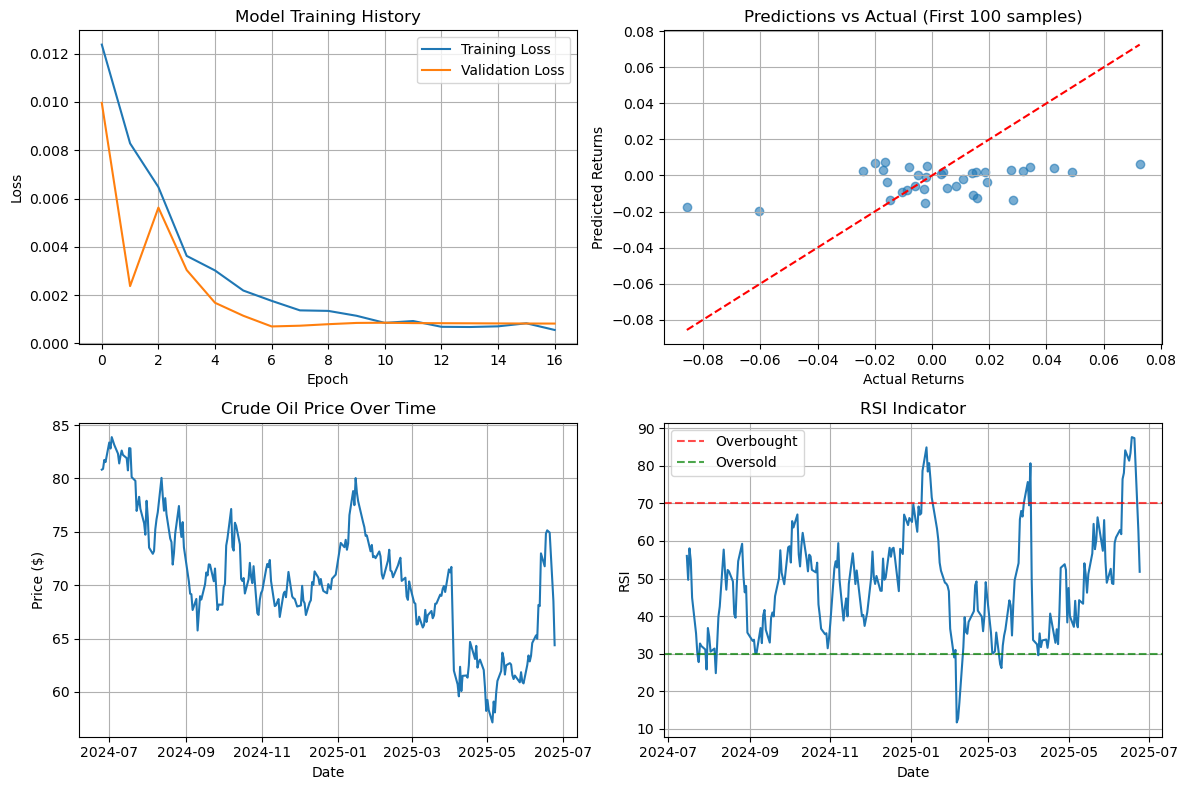


🎉 Pipeline completed successfully!

Your model is ready for backtesting!


In [3]:
# Fixed Energy Futures ML Pipeline
# This version connects all your pieces properly

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def download_and_process_data():
    """Download data and handle errors properly"""
    print("Downloading energy futures data...")
    
    energy_futures = {
        'CL=F': 'Crude Oil (WTI)',
        'BZ=F': 'Brent Crude Oil', 
        'HO=F': 'Heating Oil',
        'RB=F': 'RBOB Gasoline',
        'NG=F': 'Natural Gas'
    }
    
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    
    # Dictionary to store successfully downloaded data
    all_data = {}
    
    for symbol, name in energy_futures.items():
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)
            
            if not data.empty and len(data) > 100:  # Make sure we have enough data
                all_data[symbol] = data
                print(f"✓ Downloaded {name}: {len(data)} days")
            else:
                print(f"✗ {name}: Insufficient data")
                
        except Exception as e:
            print(f"✗ Error downloading {name}: {str(e)}")
    
    if len(all_data) == 0:
        raise Exception("No data downloaded successfully!")
    
    return all_data

def add_technical_indicators(data):
    """Add all technical indicators to a dataset"""
    
    # Make a copy to avoid modifying original data
    df = data.copy()
    
    # Moving Averages
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    
    # RSI
    delta = df['Close'].diff()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    avg_gains = gains.rolling(window=14).mean()
    avg_losses = losses.rolling(window=14).mean()
    rs = avg_gains / avg_losses
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Volume-Weighted Momentum
    price_change = df['Close'].pct_change(14)
    avg_volume = df['Volume'].rolling(window=14).mean()
    
    # Avoid division by zero
    volume_weight = df['Volume'] / avg_volume.replace(0, 1)
    vw_momentum = price_change * volume_weight
    df['VW_Momentum'] = vw_momentum.rolling(window=5).mean()
    
    return df

def create_refinery_spread(crude_data, gasoline_data, heating_oil_data):
    """Create refinery spread signal safely"""
    try:
        # Align the data by dates
        aligned_data = pd.concat([
            crude_data['Close'].rename('Crude'),
            gasoline_data['Close'].rename('Gasoline'),
            heating_oil_data['Close'].rename('HeatingOil')
        ], axis=1).dropna()
        
        if len(aligned_data) < 50:  # Need minimum data
            return pd.Series(index=crude_data.index, data=0)
        
        # Calculate ratios
        gasoline_ratio = aligned_data['Gasoline'] / aligned_data['Crude']
        heating_oil_ratio = aligned_data['HeatingOil'] / aligned_data['Crude']
        combined_ratio = (gasoline_ratio + heating_oil_ratio) / 2
        
        # Compare to moving average
        ratio_ma = combined_ratio.rolling(window=30).mean()
        spread_signal = ((combined_ratio - ratio_ma) / ratio_ma) * 100
        
        # Reindex to match crude oil data
        return spread_signal.reindex(crude_data.index, fill_value=0)
        
    except Exception as e:
        print(f"Warning: Could not create refinery spread: {e}")
        return pd.Series(index=crude_data.index, data=0)

def prepare_ml_data(data, window_size=30):
    # data is already a copy from add_technical_indicators
    data['Next_Day_Return'] = data['Close'].pct_change().shift(-1)
    
    # Select feature columns (everything except our target)
    feature_columns = [col for col in data.columns if col != 'Next_Day_Return']
    
    # Remove rows with missing data
    clean_data = data.dropna()
    
    if len(clean_data) < window_size + 50:
        raise Exception(f"Insufficient clean data: {len(clean_data)} rows")
    
    print(f"Clean data: {len(clean_data)} rows")
    print(f"Features: {feature_columns}")
    
    # Create sliding windows
    features = clean_data[feature_columns].values
    labels = clean_data['Next_Day_Return'].values
    
    X, y = [], []
    
    for i in range(len(clean_data) - window_size):
        # 30 days of features
        window_features = features[i:i + window_size]
        # Next day return
        window_label = labels[i + window_size]
        
        X.append(window_features)
        y.append(window_label)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Created {len(X)} windows of shape {X[0].shape}")
    
    return X, y, feature_columns

def create_and_train_model(X_train, y_train, X_test, y_test, input_shape):
    """Create and train the LSTM model"""
    
    # Build model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    print("Training model...")
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

def main():
    """Main execution function"""
    
    try:
        # Step 1: Download data
        print("Step 1: Downloading data...")
        all_data = download_and_process_data()
        
        # Step 2: Add indicators to all datasets
        print("\nStep 2: Adding technical indicators...")
        enhanced_data = {}
        
        for symbol, data in all_data.items():
            enhanced_data[symbol] = add_technical_indicators(data)
            print(f"✓ Added indicators to {symbol}")
        
        # Step 3: Add refinery spread to crude oil (if possible)
        print("\nStep 3: Adding refinery spread...")
        if all(symbol in enhanced_data for symbol in ['CL=F', 'RB=F', 'HO=F']):
            spread = create_refinery_spread(
                enhanced_data['CL=F'],
                enhanced_data['RB=F'],
                enhanced_data['HO=F']
            )
            enhanced_data['CL=F']['Refinery_Spread'] = spread
            print("✓ Added refinery spread to crude oil")
        else:
            print("⚠ Missing data for refinery spread")
        
        # Step 4: Prepare ML data using crude oil
        print("\nStep 4: Preparing machine learning data...")
        if 'CL=F' not in enhanced_data:
            raise Exception("Crude oil data not available!")
        
        crude_data = enhanced_data['CL=F']
        X, y, feature_columns = prepare_ml_data(crude_data, window_size=30)
        
        # Step 5: Split data
        print("\nStep 5: Splitting data...")
        split_idx = int(0.8 * len(X))
        
        X_train = X[:split_idx]
        y_train = y[:split_idx]
        X_test = X[split_idx:]
        y_test = y[split_idx:]
        
        print(f"Training samples: {len(X_train)}")
        print(f"Testing samples: {len(X_test)}")
        
        # Step 6: Normalize features
        print("\nStep 6: Normalizing features...")
        scaler = StandardScaler()
        
        # Reshape for scaling
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_train_scaled = X_train_scaled.reshape(X_train.shape)
        
        X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
        X_test_scaled = scaler.transform(X_test_reshaped)
        X_test_scaled = X_test_scaled.reshape(X_test.shape)
        
        # Step 7: Train model
        print("\nStep 7: Training model...")
        input_shape = (X_train.shape[1], X_train.shape[2])
        
        model, history = create_and_train_model(
            X_train_scaled, y_train,
            X_test_scaled, y_test,
            input_shape
        )
        
        # Step 8: Evaluate model
        print("\nStep 8: Evaluating model...")
        test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
        
        print(f"Test Loss (MSE): {test_loss:.6f}")
        print(f"Test MAE: {test_mae:.6f}")
        
        # Step 9: Make predictions
        print("\nStep 9: Making predictions...")
        predictions = model.predict(X_test_scaled, verbose=0)
        
        # Show sample predictions
        print("\nSample Predictions vs Actual:")
        print("Predicted  | Actual     | Difference")
        print("-" * 35)
        
        for i in range(min(10, len(predictions))):
            pred = predictions[i][0]
            actual = y_test[i]
            diff = abs(pred - actual)
            print(f"{pred:8.4f}   | {actual:8.4f}   | {diff:8.4f}")
        
        # Step 10: Plot results
        print("\nStep 10: Plotting results...")
        
        plt.figure(figsize=(12, 8))
        
        # Plot 1: Training history
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Predictions vs Actual
        plt.subplot(2, 2, 2)
        plt.scatter(y_test[:100], predictions[:100], alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Returns')
        plt.ylabel('Predicted Returns')
        plt.title('Predictions vs Actual (First 100 samples)')
        plt.grid(True)
        
        # Plot 3: Crude oil price
        plt.subplot(2, 2, 3)
        plt.plot(crude_data.index, crude_data['Close'])
        plt.title('Crude Oil Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.grid(True)
        
        # Plot 4: Feature importance (RSI example)
        plt.subplot(2, 2, 4)
        if 'RSI' in crude_data.columns:
            plt.plot(crude_data.index, crude_data['RSI'])
            plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
            plt.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
            plt.title('RSI Indicator')
            plt.xlabel('Date')
            plt.ylabel('RSI')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        print("\n🎉 Pipeline completed successfully!")
        print("\nYour model is ready for backtesting!")
        
        return {
            'model': model,
            'scaler': scaler,
            'data': enhanced_data,
            'predictions': predictions,
            'actual': y_test,
            'feature_columns': feature_columns
        }
        
    except Exception as e:
        print(f"❌ Error in pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the complete pipeline
if __name__ == "__main__":
    results = main()